In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod
import torch
import torch.nn.functional as F


from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from MogrifierLSTM import MogrifierLSTMCell
from utils.dataset import NCDFDatasets
from utils.trainer import Tester
from utils.trainer import Trainer
from datetime import datetime
from evonorm import EvoNorm3D
from conv2dlocal import Conv2dLocal

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()
device

device(type='cuda', index=0)

In [4]:
batch_size = 25
validation_split = 0.2
test_split = 0.2
dropout_rate = 0.2
hidden_size = 32*32
mogrify_rounds = 5
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

grid_mask_param = {'ratio':0.8, 'max_prob': 0.3, 'd1':3, 'd2': 12, 'max_epochs': 10}

In [5]:
import xarray as xr
data_path = '../../../data/dataset-ucar-1979-2015-seq5-ystep5.nc'
dataset = xr.open_dataset(data_path)
print(dataset)

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 32, lon: 32, sample: 54047, time: 5)
Coordinates:
  * lat      (lat) int32 -54 -52 -50 -48 -46 -44 -42 -40 ... -6 -4 -2 0 2 4 6 8
  * lon      (lon) int32 278 280 282 284 286 288 290 ... 330 332 334 336 338 340
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have air temperature values and are separable...


In [6]:
#In these experiments y has dimensions [batch, channel, lat, lon] as opposed to [batch, channel, time, lat, lon] to
#avoid dimension conflict with conv kernels
data = NCDFDatasets(dataset, val_split = 0.2, test_split = 0.2, cut_y=True)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [7]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)

-----Train-----
X :  torch.Size([32429, 1, 5, 32, 32])
Y :  torch.Size([32429, 1, 32, 32])
-----Val-----
X :  torch.Size([10809, 1, 5, 32, 32])
Y :  torch.Size([10809, 1, 32, 32])
-----Test-----
X :  torch.Size([10809, 1, 5, 32, 32])
Y :  torch.Size([10809, 1, 32, 32])


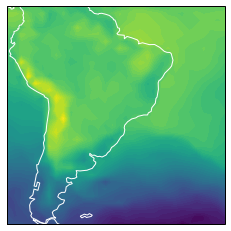

In [8]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.y[0, 0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

In [9]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

def init_seed(seed):
    np.random.seed(seed)
    
init_seed = init_seed(seed)

In [10]:
params = {'batch_size': batch_size,
          'num_workers': 4,
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

In [11]:
class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [12]:
class CustomConv2d(torch.nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1,
                 bias=False, padding_mode='zeros', weight=None):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride,
                 padding=padding, dilation=dilation,
                 bias=bias, padding_mode=padding_mode)
        
        self.padding = [kernel_size // 2, kernel_size // 2]
        
    def forward(self,input, weight=None):
        if (weight is not None):
            return F.conv2d(input, weight.permute(1,0,2,3), self.bias, self.stride,
                        self.padding, self.dilation)
        else:
            return F.conv2d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation)

In [13]:
class EncoderCNN(torch.nn.Module):
    def __init__(self, input_dimens, layer_size, kernel_size, initial_out_channels, initial_in_channels, learnable_input_count, local_weight_count, device):
        super(EncoderCNN, self).__init__()
        self.device = device
        self.layer_size = layer_size
        self.conv_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.decode_bn_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels + learnable_input_count + local_weight_count
        out_channels = initial_out_channels
        for i in range(self.layer_size):
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size))
            self.bn_layers.append(EvoNorm3D(out_channels, version = 'B0_3D'))
            self.decode_bn_layers.append(EvoNorm3D(out_channels, version = 'B0_3D'))
            in_channels = out_channels + learnable_input_count + local_weight_count
            
        self.conv_reduce = CustomConv2d(in_channels = in_channels, out_channels = 1,
                                                kernel_size = 1)
            
            
    def forward(self, x, dimens, lilw, decode=False):
        batch, channel, time, lat, lon = dimens
        if (decode):
            x = self.conv_reduce(x, self.conv_reduce.weight)
            for i in range(self.layer_size-1, -1, -1):
                x = x[:, 0:32, :, :]
                x = torch.unsqueeze(x, 2)
                x = self.decode_bn_layers[i](x)
                x = torch.squeeze(x, 2)
                x = self.conv_layers[i](x, self.conv_layers[i].weight)
        else:
            for i in range(self.layer_size):
                x = self.conv_layers[i](x)
                ch = x.size()[1]
                x = x.view(batch, ch, time, lat, lon)
                x = self.bn_layers[i](x)
                x = x.view(batch*time, ch, lat, lon)
                x = torch.cat((x,lilw), 1)
            x = self.conv_reduce(x)
        return x

In [14]:
class STModel(torch.nn.Module):
    def __init__(self, encoder_layer_size, kernel_size, out_channels, in_channels, input_dimens,
                  learnable_input_count, local_weight_count, hidden_size, device):
        super(STModel, self).__init__()
        self.device = device
        self.learnable_input_count = learnable_input_count
        self.local_weight_count = local_weight_count
        self.encoder = EncoderCNN(input_dimens = input_dimens, layer_size = encoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels, learnable_input_count = learnable_input_count, local_weight_count = local_weight_count,
                                initial_in_channels = in_channels, device=device)
        self.recurrent_encoder = torch.nn.LSTMCell(input_dimens[0]*input_dimens[1], hidden_size);
        #self.recurrent_decoder = torch.nn.LSTMCell(input_width*input_height, hidden_size);
        
        self.li_layer = Conv2dLocal(input_dimens[0], input_dimens[1], in_channels = 5, out_channels = learnable_input_count, kernel_size = 1, 
                                   bias = False)
        self.lw_layer = Conv2dLocal(input_dimens[0], input_dimens[1], in_channels = 1, out_channels = local_weight_count, kernel_size = 1, 
                                   bias = False)       
        #self.pad = torch.nn.ZeroPad2d((1,0,1,0)) 
       
        
    def forward(self, x, states, original_x = None):
        batch, channel, time, lat, lon = x.size()
        z = original_x if self.training else x
        li = torch.ones(z.squeeze(1).shape).to(self.device)
        li = self.li_layer(li).unsqueeze(2).expand(-1,-1,5,-1,-1).contiguous().view(batch*time, self.learnable_input_count, lat, lon)
        z = z.view(batch*time, channel, lat, lon)
        lw = self.lw_layer(z)
        lilw = torch.cat((li,lw), 1)
        x = x.view(batch*time, channel, lat, lon)
        
        x = torch.cat((x,lilw), 1)
        x = self.encoder(x, [batch, channel, time, lat, lon], lilw)
        
        x = x.squeeze().view(batch, time, -1)
        h = states[0]
        c = states[1]
        for i in range(time):
            h,c = self.recurrent_encoder(x[:,i,:],(h,c))
            
        x = h.contiguous().view(batch, channel, lat, lon)
        x = self.encoder(x, [batch, channel, time, lat, lon], lilw, decode=True)
        x = x.view(batch, channel+self.learnable_input_count+self.local_weight_count, lat, lon)
        return x[:,0:1,:,:]
        

In [15]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [16]:
model = STModel(encoder_layer_size = param['encoder_layer_size'], kernel_size = param['kernel_size'], out_channels = param['filter_size'],
                in_channels = train_data.x.shape[1], input_dimens = (train_data.x.shape[3], train_data.x.shape[4]),
                hidden_size = hidden_size, learnable_input_count = 2, local_weight_count = 2, device=device).to(device)
criterion = RMSELoss()
#optimizer_params = {'lr': 0.001}
#optimizer = torch.optim.Adam(net.parameters(), **optimizer_params)
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)
model

STModel(
  (encoder): EncoderCNN(
    (conv_layers): ModuleList(
      (0): CustomConv2d(5, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (1): CustomConv2d(36, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (2): CustomConv2d(36, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
    )
    (bn_layers): ModuleList(
      (0): EvoNorm3D()
      (1): EvoNorm3D()
      (2): EvoNorm3D()
    )
    (decode_bn_layers): ModuleList(
      (0): EvoNorm3D()
      (1): EvoNorm3D()
      (2): EvoNorm3D()
    )
    (conv_reduce): CustomConv2d(36, 1, kernel_size=(1, 1), stride=(1, 1), padding=[0, 0], bias=False)
  )
  (recurrent_encoder): LSTMCell(1024, 1024)
  (li_layer): Conv2dLocal(5, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (lw_layer): Conv2dLocal(1, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
)

In [17]:
model_path = os.path.join('../../../models/CFSR/1_step/STTSModel_3D_EvoNormB0_3D_GridMask_LILW_Mixed_Persistent' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, model_path, recurrent_model=True, cut_output=True, patience=7,grid_mask=grid_mask_param, lilw=True)


In [18]:
train_losses, val_losses = trainer.train_evaluate()

0.3
Train - Epoch 0, Epoch Loss: 2.659993
Val Avg. Loss: 2.106872
=> Saving a new best
Train - Epoch 1, Epoch Loss: 1.640950
Val Avg. Loss: 1.597484
=> Saving a new best
Train - Epoch 2, Epoch Loss: 1.449277
Val Avg. Loss: 1.390271
=> Saving a new best
Train - Epoch 3, Epoch Loss: 1.354598
Val Avg. Loss: 1.320196
=> Saving a new best
Train - Epoch 4, Epoch Loss: 1.302605
Val Avg. Loss: 1.361483
Train - Epoch 5, Epoch Loss: 1.261352
Val Avg. Loss: 1.284254
=> Saving a new best
Train - Epoch 6, Epoch Loss: 1.232380
Val Avg. Loss: 1.256063
=> Saving a new best
Train - Epoch 7, Epoch Loss: 1.213417
Val Avg. Loss: 1.207994
=> Saving a new best
Train - Epoch 8, Epoch Loss: 1.191520
Val Avg. Loss: 1.223663
Train - Epoch 9, Epoch Loss: 1.176064
Val Avg. Loss: 1.189278
=> Saving a new best
Train - Epoch 10, Epoch Loss: 1.160761
Val Avg. Loss: 1.161726
=> Saving a new best
Train - Epoch 11, Epoch Loss: 1.152023
Val Avg. Loss: 1.158023
=> Saving a new best
Train - Epoch 12, Epoch Loss: 1.141115
V

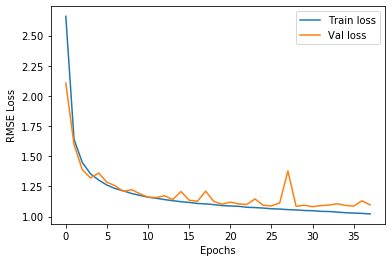

In [19]:
epochs = np.arange(1,len(val_losses))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

In [20]:
def init_hidden(batch_size, hidden_size):
    h = torch.zeros(batch_size,hidden_size, device=device)
    return (h,h)

model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        states = init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        loss = criterion(output, y)
        batch_test_loss += loss.detach().item()
test_loss = batch_test_loss/len(test_loader)
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S RMSELoss: 1.0792


In [25]:
#6 - 0.8589
#3 - 0.7920
#6 - 0.8238 **
def init_hidden(batch_size, hidden_size):
    h = torch.zeros(batch_size,hidden_size, device=device)
    return (h,h)

trainer.path = '../../../models/CFSR/1_step/STTSModel_3D_EvoNormB0_3D_GridMask_LILW_Mixed_Persistent_m06d15-h11m11s41.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
model.eval()
previous_three_steps = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        for j in range(2,5):
            previous_three_steps.append(x[4,0,j,:,:])
        x,y = x.to(device), y.to(device)
        ground_truth = y[4,0,:,:]
        states = trainer.init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        prediction = output[4,0,:,:]
        print(criterion(prediction, ground_truth))
        break

tensor(0.8972, device='cuda:0')


In [21]:
lat = dataset.variables['lat'][:]
lon = dataset.variables['lon'][:]
# extend longitude by 2
lon_extend = np.zeros(lon.size+2)
# fill in internal values
lon_extend[1:-1] = lon # fill up with original values
# fill in extra endpoints
lon_extend[0] = lon[0]-np.diff(lon)[0]
lon_extend[-1] = lon[-1]+np.diff(lon)[-1]
# calculate the midpoints
lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

# extend latitude by 2
lat_extend = np.zeros(lat.size+2)
# fill in internal values
lat_extend[1:-1] = lat
# fill in extra endpoints
lat_extend[0] = lat[0]-np.diff(lat)[0]
lat_extend[-1] = lat[-1]+np.diff(lat)[-1]
# calculate the midpoints
lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))

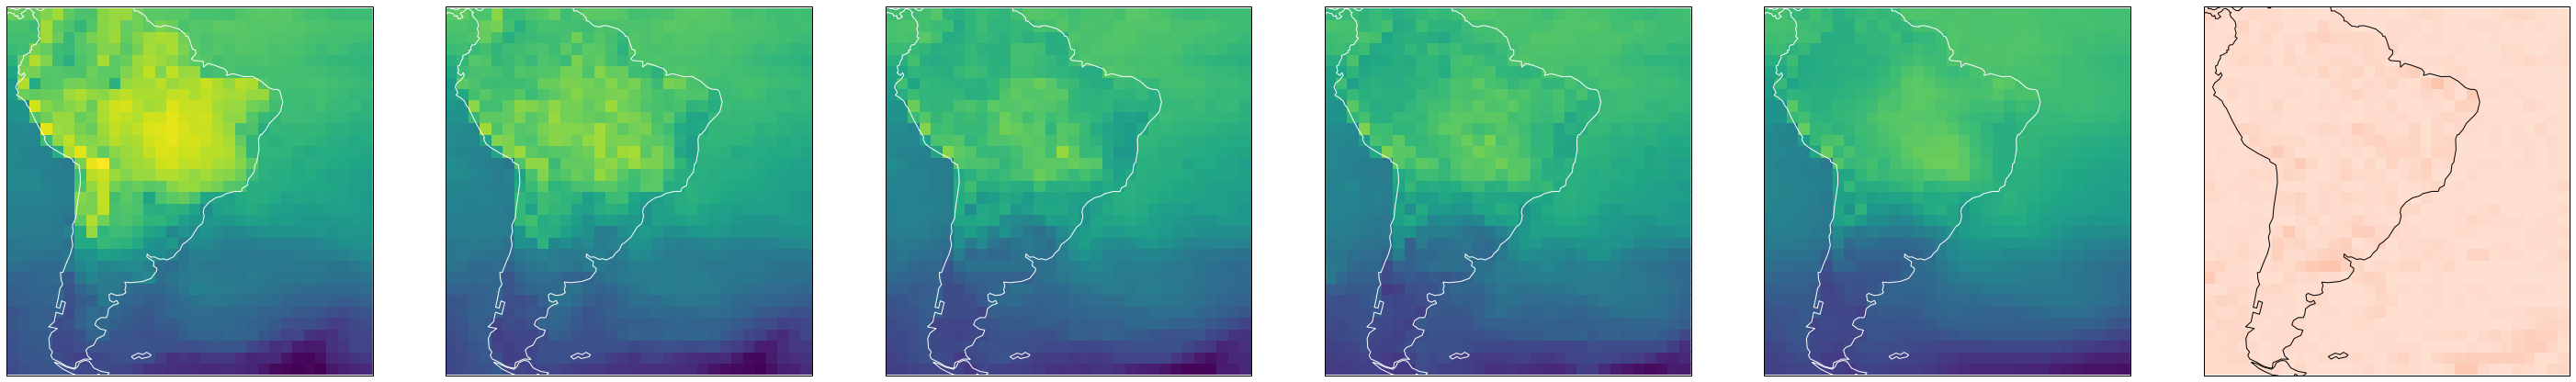

In [26]:
total = torch.cat((previous_three_steps[0].cuda(),previous_three_steps[1].cuda(),previous_three_steps[2].cuda(),ground_truth,prediction))
min_val = torch.min(total).cpu()
max_val = torch.max(total).cpu()

fig = plt.figure(figsize=(50, 50))
sst = previous_three_steps[0].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax1 = plt.subplot(1, 6, 1, projection=ccrs.PlateCarree())
ax1.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax1.coastlines(color='white')
ax1.set_extent([-83,-19,-51,8])

sst = previous_three_steps[1].cpu()
ax2 = plt.subplot(1, 6, 2, projection=ccrs.PlateCarree())
ax2.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax2.coastlines(color='white')
ax2.set_extent([-83,-19,-51,8])

sst = previous_three_steps[2].cpu()
ax3 = plt.subplot(1, 6, 3, projection=ccrs.PlateCarree())
ax3.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax3.coastlines(color='white')
ax3.set_extent([-83,-19,-51,8])

sst = ground_truth.cpu()
ax4 = plt.subplot(1, 6, 4, projection=ccrs.PlateCarree())
ax4.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax4.coastlines(color='white')
ax4.set_extent([-83,-19,-51,8])

sst = prediction.cpu()
ax5 = plt.subplot(1, 6, 5, projection=ccrs.PlateCarree())
ax5.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax5.coastlines(color='white')
ax5.set_extent([-83,-19,-51,8])
fig.tight_layout()

sst = abs(ground_truth-prediction).cpu()
ax5 = plt.subplot(1, 6, 6, projection=ccrs.PlateCarree())
ax5.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val, cmap='Reds')
ax5.coastlines(color='black')
ax5.set_extent([-83,-19,-51,8])
fig.tight_layout()
plt.show()

In [21]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
def report_regression_results(y_true, y_pred):
    # Print multiple regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    adjusted_r2 =  1.0 - ( mse / y_true.var() )
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('Adjusted r2: ', round(adjusted_r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    # save a plot with the residuals
    plt.scatter(y_pred,(y_true - y_pred),edgecolors='black')
    plt.title('Fitted vs. residuals plot')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()
    f.savefig("report-experiment1.pdf", bbox_inches='tight')
    
def report_explained_variance(y_true, y_pred):
    batch, ch, lat, lon = y_true.shape
    explained_variance = 0
    for i in range(batch):
        explained_variance += metrics.explained_variance_score(y_true[i,0,:,:], y_pred[i,0,:,:])
    return explained_variance / (batch)

def report_r2(y_true, y_pred):
    batch, ch, lat, lon = y_true.shape
    r2 = 0
    ar2 = 0
    for i in range(batch):
        mse = metrics.mean_squared_error(y_true[i,0,:,:], y_pred[i,0,:,:]) 
        r2 += metrics.r2_score(y_true[i,0,:,:], y_pred[i,0,:,:])
        ar2 +=  1.0 - ( mse / y_true[i,0,:,:].var() )
    r2 = r2/(batch)
    ar2 = ar2/(batch)
    return r2, ar2

def plot_residual_fitted(y_true, y_pred):
    plt.scatter(y_pred,(y_true - y_pred), alpha=0.5)
    plt.title('ST-RFD-B03D + GridMask + LILW')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()

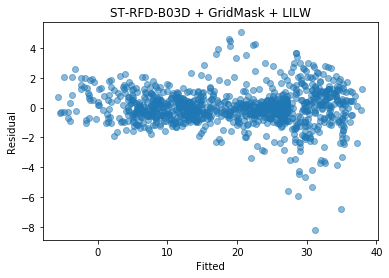

STConvS2S: 1.0792
Explained variance:  0.9812
r2:  0.9795
ar2:  0.982


In [22]:
trainer.path = '../../../models/CFSR/1_step/STTSModel_3D_EvoNormB0_3D_GridMask_LILW_m06d06-h22m22s06.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
batch_explained_variance = 0.0
batch_r2 = 0.0
batch_ar2 = 0.0
model.eval()
y_true = None
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        states = trainer.init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        output = model(x, states)
        loss = criterion(output, y)
        y_true = y.cpu().numpy()
        y_pred = output.cpu().numpy()
        if (i == 0):
            plot_residual_fitted(y_true[0,0,:,:], y_pred[0,0,:,:])
        batch_test_loss += loss.detach().item()
        batch_explained_variance += report_explained_variance(y_true, y_pred)
        r2, ar2 = report_r2(y_true, y_pred)
        batch_r2 += r2
        batch_ar2 += ar2
        
test_loss = batch_test_loss/len(test_loader)
explained_variance = batch_explained_variance/len(test_loader)
r2 = batch_r2/len(test_loader)
ar2 = batch_ar2/len(test_loader)
print(f'STConvS2S: {test_loss:.4f}')
print('Explained variance: ', round(explained_variance,4))
print('r2: ', round(r2,4))
print('ar2: ', round(ar2,4))